# Import Packages and Classifiers

In [1]:
#!pip install --user scikit-learn

In [2]:
#!pip install --user matplotlib

In [3]:
#!pip install --user pandas

In [4]:
#!pip install --user numpy

In [5]:
#!pip install --user seaborn

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import accuracy_score
import time

from sklearn.model_selection import learning_curve
import pandas as pd 
import numpy as np  
from sklearn import tree


https://scikit-learn.org/stable/modules/cross_validation.html

# Import Data 

In [7]:
hr_data = pd.read_csv("hr_data.csv")
bank_data = pd.read_csv("bank-marketing.csv")

# First Dataset 
https://www.kaggle.com/dhirajnirne/bank-marketing

## Prep Data for Modeling 

In [8]:
bank_data.columns

Index(['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'response'],
      dtype='object')

In [9]:
categorical_cols = ['age group', 'eligible', 'job', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'poutcome']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(bank_data[i].unique())
    bank_data[i] = le.transform(bank_data[i])

In [10]:
target = 'response'
cols = ['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

#splitn into training and testing data sets
train, test = train_test_split(bank_data, test_size=0.3, random_state = 30)

In [11]:
train_sizes = np.arange(1, len(train), 1500).tolist()#.append(len(train))
train_sizes.append(len(train)-1)


## Decision Tree with Pruning 
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/

In [12]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities


In [13]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    test_tree = DecisionTreeClassifier(ccp_alpha = i)
    
    test_tree.fit(train[cols], train[target])
    y_train_pred = test_tree.predict(train[cols])
    y_test_pred = test_tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = accuracy_score(test[target], y_test_pred) if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

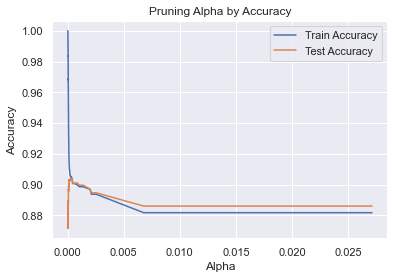

In [14]:
sns.set()
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [15]:
start_time = time.time()
no_prune_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0)
no_prune_tree.fit(train[cols], train[target])
no_prune_tree_runtime = time.time() - start_time
no_prune_tree_training_error = 1 - accuracy_score(train[target], no_prune_tree.predict(train[cols]))
no_prune_tree_error = 1 - accuracy_score(test[target], no_prune_tree.predict(test[cols]))

In [16]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

In [17]:
plt.figure(figsize=(200, 200), dpi=100)
tree.plot_tree(final_tree)
plt.show()

In [18]:
max_score_alpha

0.0002410715672386773

In [19]:
print(no_prune_tree.tree_.node_count)
print(no_prune_tree.tree_.max_depth)


5115
30


In [20]:
print(final_tree.tree_.node_count)
print(final_tree.tree_.max_depth)

89
12


In [21]:
final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, accuracy_score(test[target], final_tree.predict(test[cols])), final_tree_runtime] ).T

In [22]:
bad_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=.1)
bad_tree.fit(train[cols], train[target])
print(bad_tree.tree_.node_count)
print(bad_tree.tree_.max_depth )

1
0


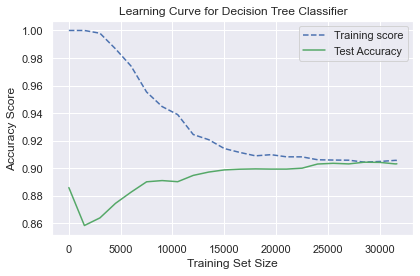

In [23]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [24]:
final_tree.feature_importances_

array([0.03577221, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04538395, 0.        , 0.03676602, 0.00800752,
       0.15017439, 0.51014027, 0.        , 0.07988693, 0.        ,
       0.1338687 ])

In [25]:
pd.DataFrame({
    'feature': cols,
    'importance': final_tree.feature_importances_
})

feature  importance
0                 age    0.035772
1           age group    0.000000
2            eligible    0.000000
3                 job    0.000000
4              salary    0.000000
5             marital    0.000000
6           education    0.000000
7   marital-education    0.000000
8            targeted    0.000000
9             default    0.000000
10            balance    0.000000
11            housing    0.045384
12               loan    0.000000
13            contact    0.036766
14                day    0.008008
15              month    0.150174
16           duration    0.510140
17           campaign    0.000000
18              pdays    0.079887
19           previous    0.000000
20           poutcome    0.133869

## Neural Network
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [27]:
start_time = time.time()
nn = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, accuracy_score(test[target], nn.predict(test[cols])), nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(


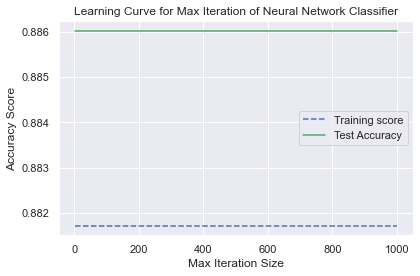

In [28]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100 , dtype = int)
for i in max_iter:
    classifier  = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = i)
    classifier.fit(train[cols], train[target].apply(lambda x: int()))
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration of Neural Network Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


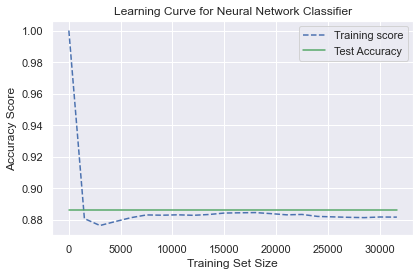

In [29]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

In [30]:
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = accuracy_score(test[target], y_test_pred) if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

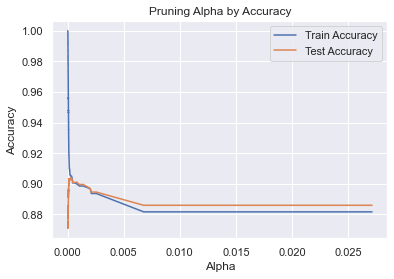

In [31]:
sns.set()
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [32]:
max_score_alpha

0.0002410715672386773

In [33]:
start_time = time.time()
gbc = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
gbc.fit(train[cols], train[target])
gbc_runtime = time.time() - start_time
gbc_training_error = 1 - accuracy_score(train[target], gbc.predict(train[cols]))
gbc_error = 1 - accuracy_score(test[target], gbc.predict(test[cols]))

gbc_row = pd.DataFrame(['Gradient Boosting Tree', gbc_training_error, gbc_error, accuracy_score(test[target], gbc.predict(test[cols])), gbc_runtime] ).T

In [34]:
gbc.max_depth

3

In [35]:
min_node = 0
max_node = 0
for i in range(100):
    
    max_node = gbc.estimators_[i, 0].tree_.node_count if max_node < gbc.estimators_[i, 0].tree_.node_count else max_node
    min_node = gbc.estimators_[i, 0].tree_.node_count if min_node > gbc.estimators_[i, 0].tree_.node_count else min_node  
               
    #print(gbc.estimators_[i, 0].tree_.node_count)          
               

In [36]:
print(max_node)
print(min_node)

15
0


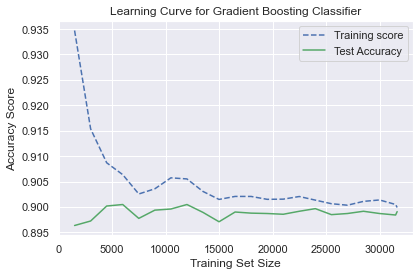

In [37]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")


plt.title("Learning Curve for Gradient Boosting Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Support Vector Machines 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py

### Linear 

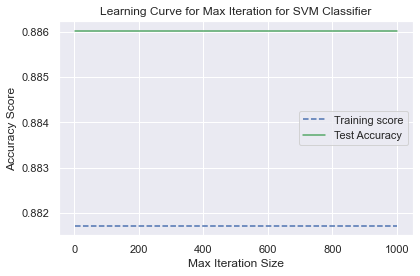

In [38]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

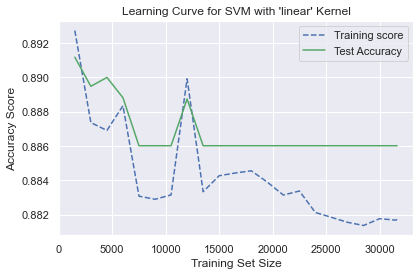

In [39]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel= 'linear'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'linear' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Poly

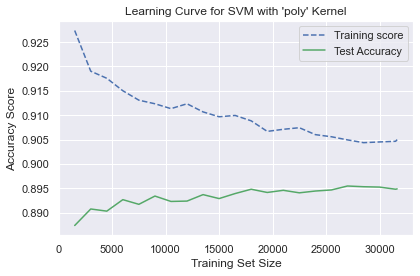

In [40]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'poly' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

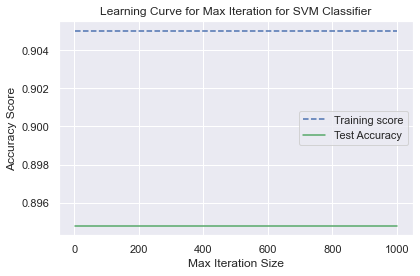

In [41]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [42]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, accuracy_score(test[target], clf.predict(test[cols])), clf_runtime] ).T

## K Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


Text(0.5, 1.0, 'Test Accuracy by Number of Neighbors')

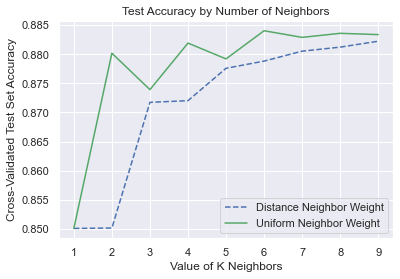

In [43]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
# this is identical to the one we generated above

distance_results = grid.cv_results_.get('mean_test_score')[1::2]
uniform_results = grid.cv_results_.get('mean_test_score')[::2]


plt.plot(k_range, distance_results, '--', color="b",  label="Distance Neighbor Weight")
plt.plot(k_range, uniform_results, color="g", label="Uniform Neighbor Weight")
plt.legend(loc="best")
plt.xlabel('Value of K Neighbors')
plt.ylabel('Cross-Validated Test Set Accuracy')
plt.title('Test Accuracy by Number of Neighbors')

In [44]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'), weights = grid.best_params_.get('weights'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, accuracy_score(test[target], neigh.predict(test[cols])), neigh_runtime]).T 

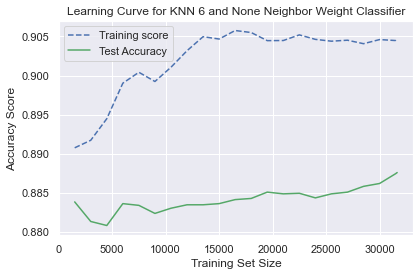

In [45]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1:
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
neighbor_weight = "uniform" if grid.best_params_.get('weight') == "None" else grid.best_params_.get('weight')
plt.title(f"Learning Curve for KNN {num_of_neighbors} and {neighbor_weight} Neighbor Weight Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [46]:
final_df = neigh_row.append(clf_row).append(gbc_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Accuracy', 'Training Time']
final_df

Classifier Name Training Error Testing Error  Accuracy Training Time
0      K Nearest Neighbor       0.095712      0.112504  0.887496      0.006849
0  Support Vector Machine       0.118273      0.113978  0.886022      25.64486
0  Gradient Boosting Tree       0.100104      0.100929  0.899071      3.274422
0          Neural Network       0.118273      0.113978  0.886022      1.427671
0           Decision Tree       0.094606      0.096211  0.903789      0.164263

# Second Dataset   

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

## Prep Data for Modeling 

In [47]:
hr_data.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [48]:
categorical_cols = ['city', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(hr_data[i].unique())
    hr_data[i] = le.transform(hr_data[i])



In [49]:
target = 'target'
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']

#splitn into training and testing data sets
train, test = train_test_split(hr_data, test_size=0.3, random_state = 30)
train_sizes = np.arange(1, len(train), 1000).tolist()
train_sizes.append(len(train)-1)

## Decision Tree with Pruning 

In [50]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = accuracy_score(test[target], y_test_pred) if max_score < accuracy_score(test[target], y_test_pred) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

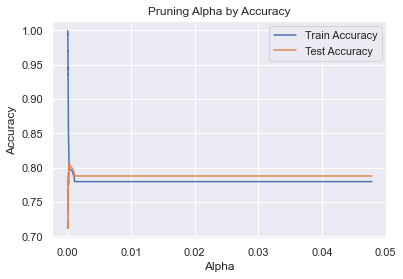

In [51]:
sns.set()
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [52]:
max_score_alpha

0.00025363661692029416

In [53]:
start_time = time.time()
no_prune_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0)
no_prune_tree.fit(train[cols], train[target])
no_prune_tree_runtime = time.time() - start_time
no_prune_tree_training_error = 1 - accuracy_score(train[target], no_prune_tree.predict(train[cols]))
no_prune_tree_error = 1 - accuracy_score(test[target], no_prune_tree.predict(test[cols]))

In [54]:
print(no_prune_tree.tree_.node_count)
print(no_prune_tree.tree_.max_depth)

6131
42


In [55]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, accuracy_score(test[target], final_tree.predict(test[cols])), final_tree_runtime] ).T

In [56]:
print(final_tree.tree_.node_count)
print(final_tree.tree_.max_depth)

65
9


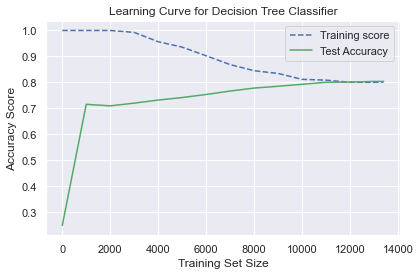

In [57]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [58]:
pd.DataFrame({
    'feature': cols,
    'importance': final_tree.feature_importances_
})

feature  importance
0                     city    0.037240
1   city_development_index    0.523659
2                   gender    0.006463
3      relevent_experience    0.020746
4      enrolled_university    0.002853
5          education_level    0.100541
6         major_discipline    0.008217
7               experience    0.009374
8             company_size    0.242458
9             company_type    0.010959
10            last_new_job    0.025284
11          training_hours    0.012207

In [59]:
hr_data.city_development_index.unique()

array([0.92 , 0.776, 0.624, 0.789, 0.767, 0.764, 0.762, 0.913, 0.926,
       0.827, 0.843, 0.804, 0.855, 0.887, 0.91 , 0.884, 0.924, 0.666,
       0.558, 0.923, 0.794, 0.754, 0.939, 0.55 , 0.865, 0.698, 0.893,
       0.796, 0.866, 0.682, 0.802, 0.579, 0.878, 0.897, 0.949, 0.925,
       0.896, 0.836, 0.693, 0.769, 0.775, 0.903, 0.555, 0.727, 0.64 ,
       0.516, 0.743, 0.899, 0.915, 0.689, 0.895, 0.89 , 0.847, 0.527,
       0.766, 0.738, 0.647, 0.795, 0.74 , 0.701, 0.493, 0.84 , 0.691,
       0.735, 0.742, 0.479, 0.722, 0.921, 0.848, 0.856, 0.898, 0.83 ,
       0.73 , 0.68 , 0.725, 0.556, 0.448, 0.763, 0.745, 0.645, 0.788,
       0.78 , 0.512, 0.739, 0.563, 0.518, 0.824, 0.487, 0.649, 0.781,
       0.625, 0.807, 0.664])

## Neural Network

In [60]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
accuracy_score(test[target], nn.predict(test[cols]))

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.761482254697286

In [61]:
start_time = time.time()
nn = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, accuracy_score(test[target], final_tree.predict(test[cols])), nn_runtime] ).T
print(accuracy_score(test[target], nn.predict(test[cols])))

0.750347947112039


/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

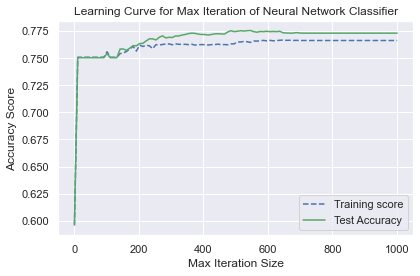

In [62]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = i)
    classifier.fit(train[cols], train[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration of Neural Network Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed t

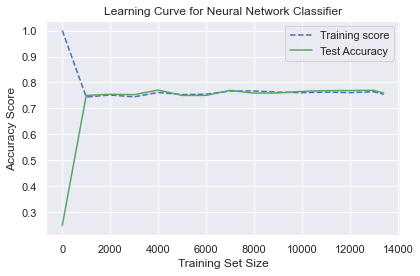

In [63]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")


plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 

In [64]:
alphas = np.linspace(0,.3, num = 100)
accuracy_train, accuracy_test = [], []

In [65]:
for i in alphas:
    
    tree = GradientBoostingClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])

    accuracy_train.append(tree.score(train[cols], train[target]))
    accuracy_test.append(tree.score(test[cols], test[target]))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < tree.score(train[cols], train[target]) else max_score_alpha  
    max_score = tree.score(test[cols], test[target]) if max_score < tree.score(test[cols], test[target]) else max_score  


[Text(0.5, 1.0, 'Pruning Alpha by Accuracy')]

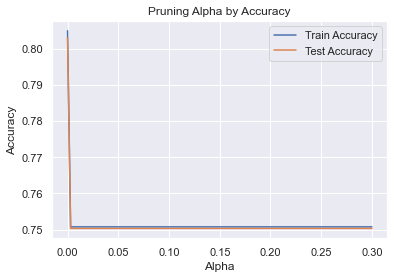

In [66]:
sns.set()
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy").set(xlabel='Alpha', ylabel='Accuracy')
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy").set(title='Pruning Alpha by Accuracy')

In [67]:
max_score_alpha

0.00025363661692029416

In [68]:
start_time = time.time()
gbc = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
gbc.fit(train[cols], train[target])
gbc_runtime = time.time() - start_time
gbc_training_error = 1 - accuracy_score(train[target], gbc.predict(train[cols]))
gbc_error = 1 - accuracy_score(test[target], gbc.predict(test[cols]))

gbc_row = pd.DataFrame(['Gradient Boosting Tree', gbc_training_error, gbc_error, accuracy_score(test[target], gbc.predict(test[cols])), gbc_runtime] ).T

In [69]:
gbc.max_depth

3

In [70]:
min_node = 0
max_node = 0
for i in range(100):
    
    max_node = gbc.estimators_[i, 0].tree_.node_count if max_node < gbc.estimators_[i, 0].tree_.node_count else max_node
    min_node = gbc.estimators_[i, 0].tree_.node_count if min_node > gbc.estimators_[i, 0].tree_.node_count else min_node  


In [71]:
print(max_node)
print(min_node)

13
0


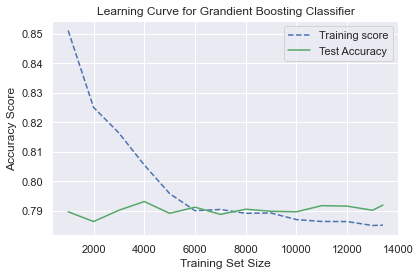

In [72]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1:
        train_data_subset = train.head(i)
        classifier  = GradientBoostingClassifier(random_state=0, ccp_alpha=max_score_alpha)
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")


plt.title("Learning Curve for Grandient Boosting Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Support Vector Machines 

In [73]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, accuracy_score(test[target], clf.predict(test[cols])), clf_runtime] ).T

### Linear Kernel

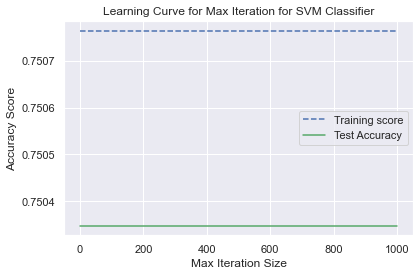

In [74]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

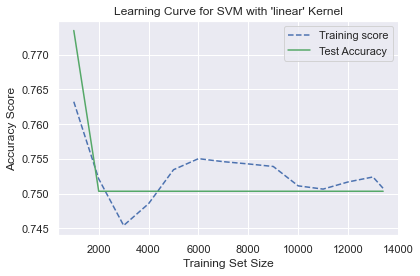

In [75]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'linear' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Poly Kernel

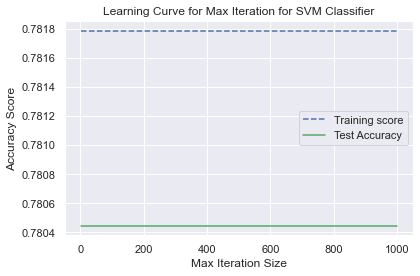

In [76]:
test_accuracy = []
train_accuracy = []
max_iter = np.linspace(1, 1001, num = 100)
for i in max_iter:
    classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
    classifier.fit(train[cols], train[target])
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(max_iter, train_accuracy, '--', color="b",  label="Training score")
plt.plot(max_iter, test_accuracy, color="g", label="Test Accuracy")
plt.title("Learning Curve for Max Iteration for SVM Classifier")
plt.xlabel("Max Iteration Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

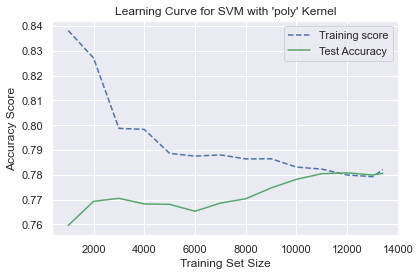

In [77]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(kernel = 'poly'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for SVM with 'poly' Kernel")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## K Nearest Neighbors

Text(0.5, 1.0, 'Test Accuracy by Number of Neighbors')

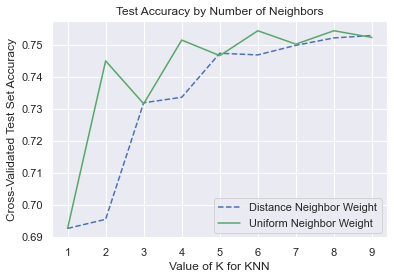

In [78]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
distance_results = grid.cv_results_.get('mean_test_score')[1::2]
uniform_results = grid.cv_results_.get('mean_test_score')[::2]

plt.plot(k_range, distance_results, '--', color="b",  label="Distance Neighbor Weight")
plt.plot(k_range, uniform_results, color="g", label="Uniform Neighbor Weight")
plt.legend(loc="best")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Test Set Accuracy')
plt.title('Test Accuracy by Number of Neighbors')

In [79]:
print(grid.best_params_.get('n_neighbors'))

6


In [80]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, accuracy_score(test[target], neigh.predict(test[cols])), neigh_runtime]).T 

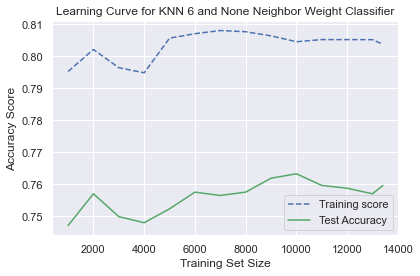

In [81]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
neighbor_weight = "uniform" if grid.best_params_.get('weight') == "None" else grid.best_params_.get('weight')
plt.title(f"Learning Curve for KNN {num_of_neighbors} and {neighbor_weight} Neighbor Weight Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [82]:
final_df2 = neigh_row.append(clf_row).append(gbc_row).append(nn_row).append(final_tree_row)
final_df2.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Accuracy', 'Training Time']
final_df2

Classifier Name Training Error Testing Error  Accuracy Training Time
0      K Nearest Neighbor       0.196495      0.242171  0.757829      0.013351
0  Support Vector Machine       0.249217      0.249652  0.750348      3.834394
0  Gradient Boosting Tree        0.21484      0.208072  0.791928       0.84333
0          Neural Network       0.249217      0.249652   0.80515      2.424955
0           Decision Tree       0.198807       0.19485   0.80515      0.061144